|Name:| Tufan Kundu|
|--|--|
|Registration no:| 24MDT0184|
|Course Name:| Deep Learning Lab|
|Course Code:| PMDS603P|
|Experiment:| 13|
|Date:| 30 October,2025|

## Question 1: Today, we will look at how we can implement autoencoders in  some specific scenarios. First, we will look at the denoising autoencoder that  can be used to perform some denoising tasks with respect to images. We will  work with MNIST Images for the task.

### Importing the necessary libraries

In [1]:
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

2025-10-30 07:28:50.609534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761809330.818599      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761809330.894862      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
 (train_images,_),(test_images, _) = mnist.load_data()
 train_images = train_images.astype('float32')/255.0
 test_images = test_images.astype('float32')/255.0
 train_images = np.reshape(train_images, (len(train_images), 28,28,1))
 test_images = np.reshape(test_images, (len(test_images), 28,28,1))
 print("Train Shape:", train_images.shape,"Test Shape:", test_images.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train Shape: (60000, 28, 28, 1) Test Shape: (10000, 28, 28, 1)


In [3]:
train_images, val_images = train_test_split(train_images, test_size = 0.2, random_state=42)
noise_factor = 0.5

## Adding noise to the data
train_noisy = train_images+noise_factor*np.random.normal(loc = 0.0, scale = 1.0, size = train_images.shape)
val_noisy = val_images+noise_factor*np.random.normal(loc = 0.0, scale = 1.0, size = val_images.shape)
test_noisy = test_images+noise_factor*np.random.normal(loc = 0.0, scale = 1.0, size = test_images.shape)
train_noisy = np.clip(train_noisy, 0.,1.)
val_noisy = np.clip(val_noisy,0.,1.)
test_noisy = np.clip(test_noisy, 0.,1.)
print("Train noisy:", train_noisy.shape, "val noisy:", val_noisy.shape)

Train noisy: (48000, 28, 28, 1) val noisy: (12000, 28, 28, 1)


### Plotting the original ans noisy images

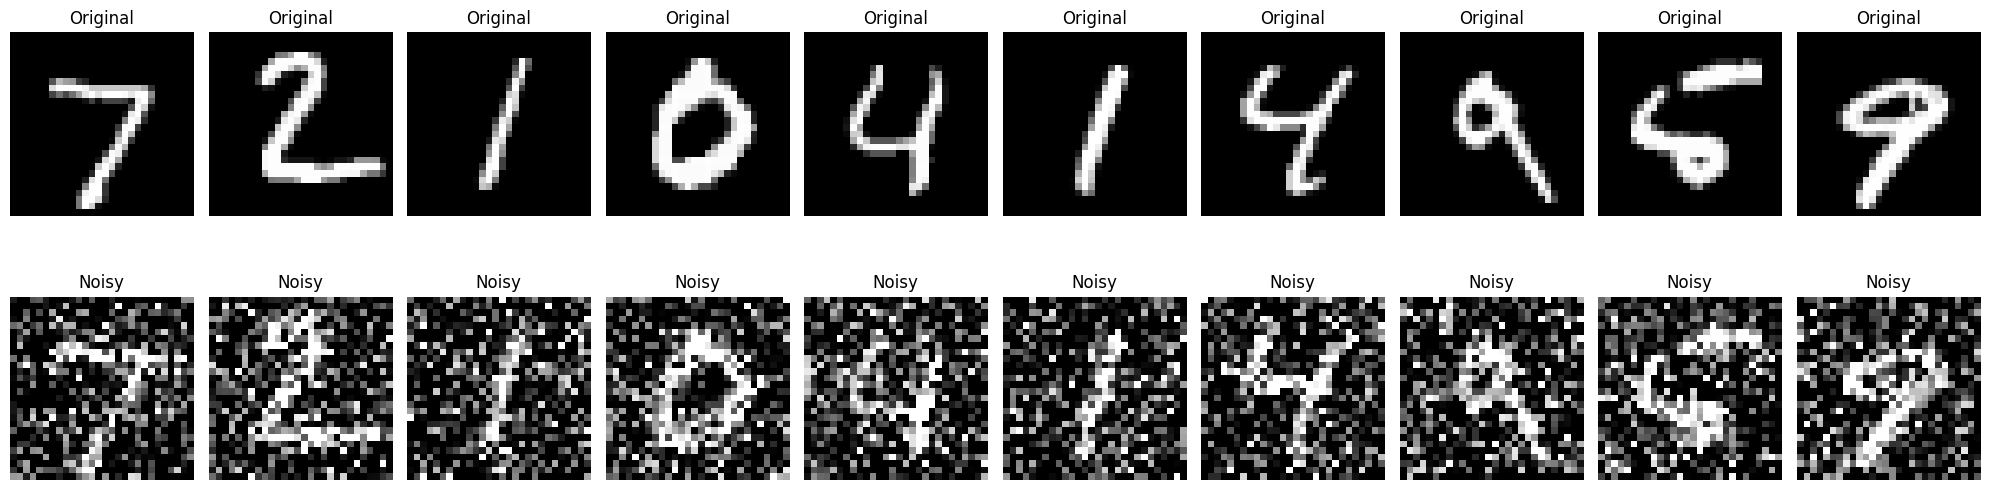

In [4]:
n = 10
plt.figure(figsize = (20,6))
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap = 'gray')
    plt.title("Original")
    ax.axis("off")
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(test_noisy[i].reshape(28,28), cmap = "gray")
    plt.title("Noisy")
    ax.axis("off")
    
plt.tight_layout()
plt.show()

### Building the model

In [5]:
model = Sequential()

## Encoder
 
model.add(Conv2D(32,(3,3), activation='relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))

## Decoder 

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1,(3,3), activation = 'sigmoid', padding = 'same'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761809348.112068      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761809348.112753      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True, verbose = 1)
history = model.fit(train_noisy, train_images, epochs = 50, batch_size = 128, shuffle = True, validation_data = (val_noisy,val_images), verbose = 1, callbacks = [early_stopping])

Epoch 1/50


I0000 00:00:1761809353.014337      99 service.cc:148] XLA service 0x7e3484004ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761809353.015112      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761809353.015128      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761809353.356553      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 27/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7101 - loss: 0.5446

I0000 00:00:1761809356.012641      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7943 - loss: 0.2430 - val_accuracy: 0.8122 - val_loss: 0.1186
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8108 - loss: 0.1144 - val_accuracy: 0.8123 - val_loss: 0.1082
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8115 - loss: 0.1077 - val_accuracy: 0.8129 - val_loss: 0.1048
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8123 - loss: 0.1045 - val_accuracy: 0.8121 - val_loss: 0.1035
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8126 - loss: 0.1023 - val_accuracy: 0.8129 - val_loss: 0.1013
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8123 - loss: 0.1009 - val_accuracy: 0.8127 - val_loss: 0.1006
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8132 - loss: 0.0997 - val_accuracy: 0.8136 - val_loss: 0.0995
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8130 - loss: 0.0988 - val_accuracy: 0.8132 - va

In [8]:
res = model.evaluate(test_noisy, test_images, verbose=1)
print(f"Test loss: {res[0]:.4f}, Test accuracy: {res[1]*100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8199 - loss: 0.0928
Test loss: 0.0934, Test accuracy: 81.27%


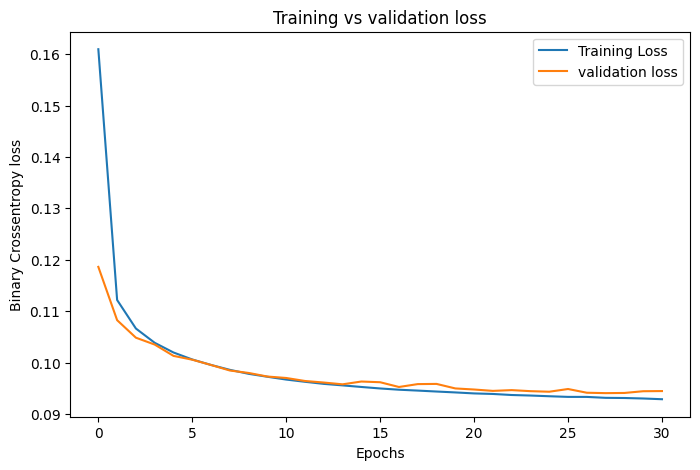

In [9]:
plt.figure(figsize = (8,5))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title("Training vs validation loss")
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy loss")
plt.legend()
plt.show()

In [10]:
denoised_images = model.predict(test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


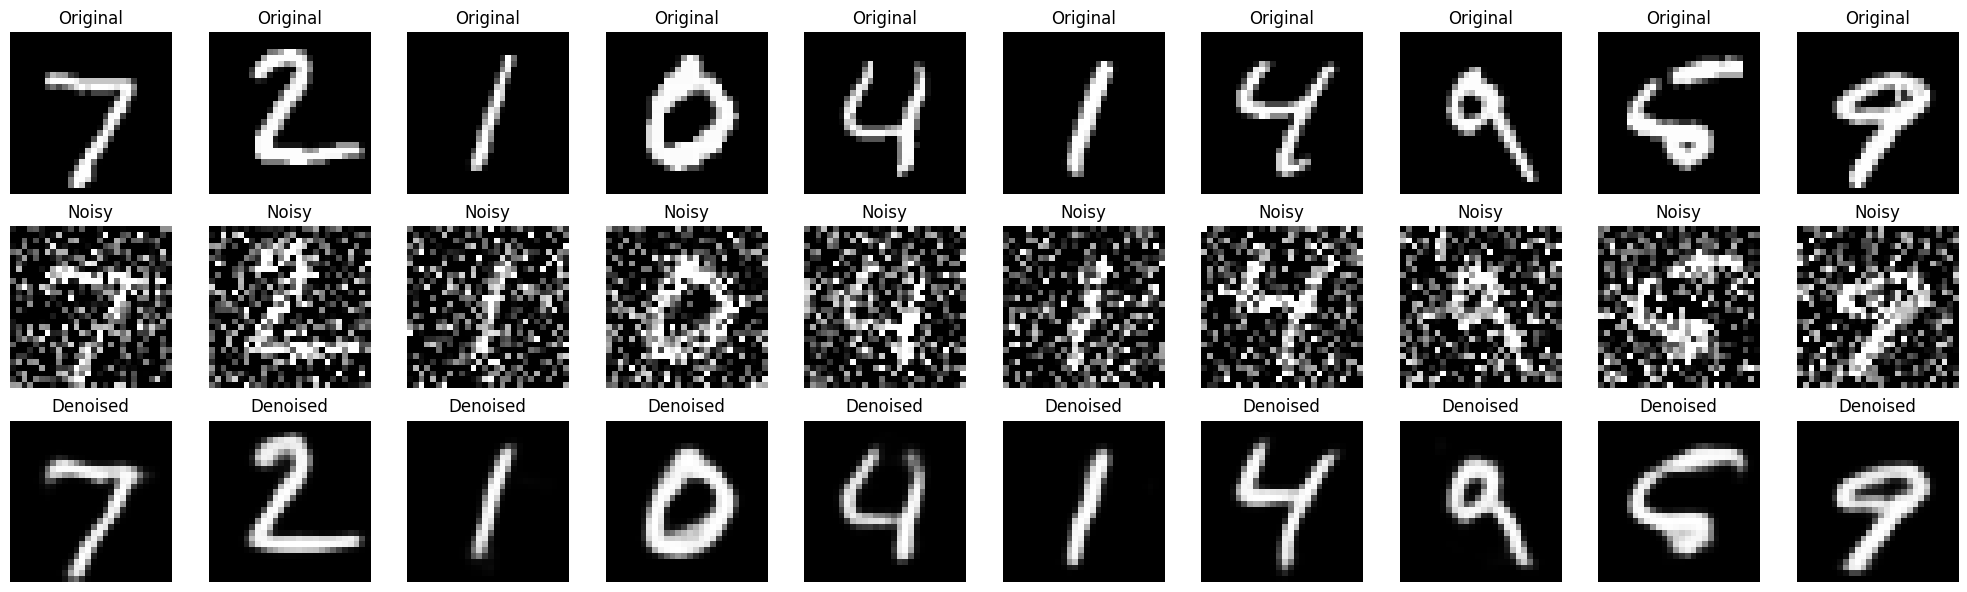

In [11]:
n = 10
plt.figure(figsize = (20,6))
for i in range(n):
    ax = plt.subplot(3,n,i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap = 'gray')
    plt.title("Original")
    ax.axis("off")
    
    ax = plt.subplot(3,n,i+1+n)
    plt.imshow(test_noisy[i].reshape(28,28), cmap = "gray")
    plt.title("Noisy")
    ax.axis("off")
    
    ax = plt.subplot(3,n,i+1+2*n)
    plt.imshow(denoised_images[i].reshape(28,28), cmap = "gray")
    plt.title("Denoised")
    ax.axis("off")
plt.tight_layout()
plt.show()


## Q2- Model fitting with mse

In [12]:
model = Sequential()
 
## Encoder
model.add(Conv2D(32,(3,3), activation='relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))

## Decoder 
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1,(3,3), activation = 'linear', padding = 'same'))

model.compile(optimizer='adam', loss = 'mean_squared_error')
history = model.fit(train_noisy, train_images, epochs = 50, batch_size = 128, shuffle = True, validation_data = (val_noisy,val_images), verbose = 1, callbacks = [early_stopping])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0412 - val_loss: 0.0172
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0164 - val_loss: 0.0146
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0143 - val_loss: 0.0137
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0117 - val_loss: 0.0119
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

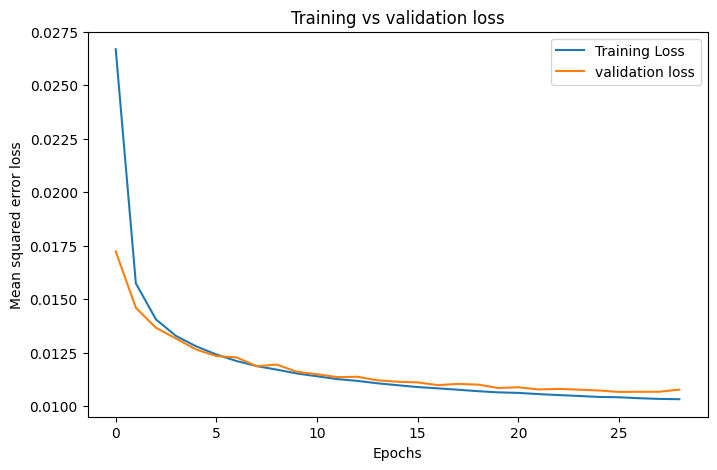

In [13]:
 plt.figure(figsize = (8,5))
 plt.plot(history.history['loss'], label = 'Training Loss')
 plt.plot(history.history['val_loss'], label = 'validation loss')
 plt.title("Training vs validation loss")
 plt.xlabel("Epochs")
 plt.ylabel("Mean squared error loss")
 plt.legend()
 plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


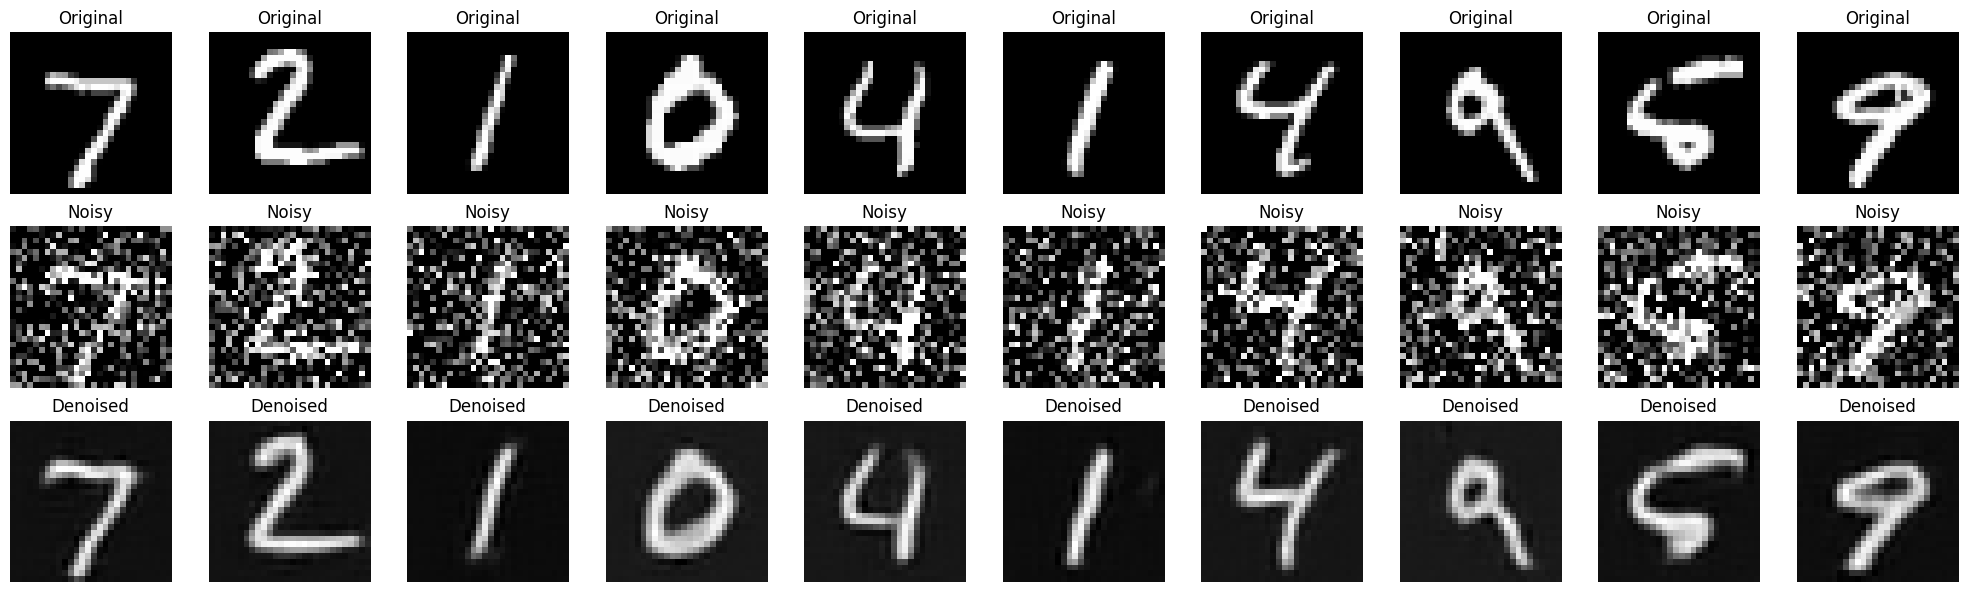

In [14]:
denoised_images = model.predict(test_noisy)
 
n = 10
plt.figure(figsize = (20,6))
for i in range(n):
    ax = plt.subplot(3,n,i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap = 'gray')
    plt.title("Original")
    ax.axis("off")
        
    ax = plt.subplot(3,n,i+1+n)
    plt.imshow(test_noisy[i].reshape(28,28), cmap = "gray")
    plt.title("Noisy")
    ax.axis("off")
        
    ax = plt.subplot(3,n,i+1+2*n)
    plt.imshow(denoised_images[i].reshape(28,28), cmap = "gray")
    plt.title("Denoised")
    ax.axis("off")
        
plt.tight_layout()
plt.show()

 ## Question 3: Try to implement a denoising autoencoder for CIFAR10 dataset  and come up with your findings.

In [15]:
from tensorflow.keras.datasets import cifar10

(train_images,_),(test_images, _) = cifar10.load_data()
train_images = train_images.astype('float32')/255.0
test_images = test_images.astype('float32')/255.0

train_images = np.reshape(train_images, (len(train_images), 32,32,3))
test_images = np.reshape(test_images, (len(test_images), 32,32,3))

print("Train Shape:", train_images.shape,"Test Shape:", test_images.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train Shape: (50000, 32, 32, 3) Test Shape: (10000, 32, 32, 3)


In [16]:
train_images, val_images = train_test_split(train_images, test_size = 0.2, random_state=42)
 
noise_factor = 0.1
train_noisy = train_images+noise_factor*np.random.normal(loc = 0.0, scale = 1.0, size = train_images.shape)
val_noisy = val_images+noise_factor*np.random.normal(loc = 0.0, scale = 1.0, size = val_images.shape)
test_noisy = test_images+noise_factor*np.random.normal(loc = 0.0, scale = 1.0, size = test_images.shape)
train_noisy = np.clip(train_noisy, 0.,1.)
val_noisy = np.clip(val_noisy,0.,1.)
test_noisy = np.clip(test_noisy, 0.,1.)
print("Train noisy:", train_noisy.shape, "val noisy:", val_noisy.shape)

Train noisy: (40000, 32, 32, 3) val noisy: (10000, 32, 32, 3)


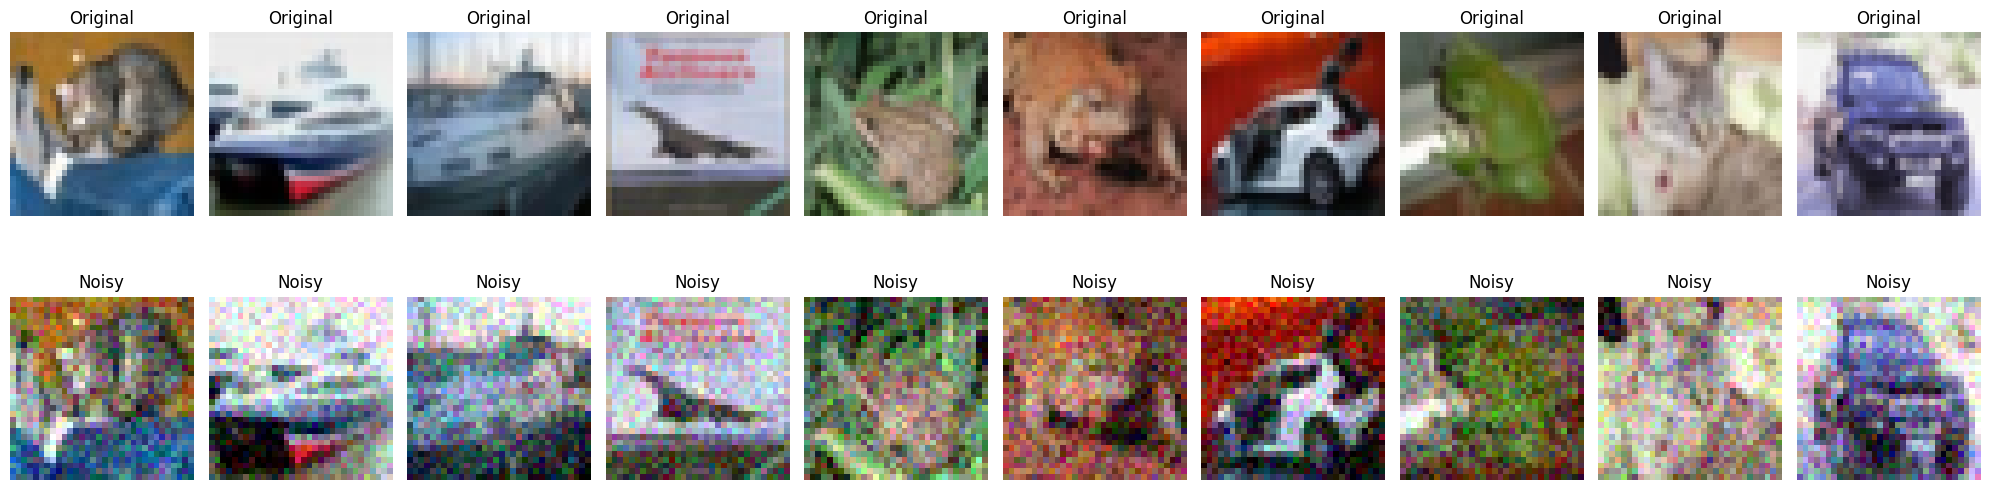

In [17]:
n = 10
 
plt.figure(figsize = (20,6))
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(test_images[i].reshape(32,32,3))
    plt.title("Original")
    ax.axis("off")
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(test_noisy[i].reshape(32,32,3))
    plt.title("Noisy")
    ax.axis("off")
        
plt.tight_layout()
plt.show()

### Building the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout

model = Sequential()

##Encoder 
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Dropout(0.3))

##Decoder
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2,2)))

model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))  

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

history = model.fit(train_noisy, train_images,
                    epochs=50,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(val_noisy, val_images),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - accuracy: 0.6022 - loss: 0.6042 - val_accuracy: 0.5496 - val_loss: 0.5980 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7110 - loss: 0.5714 - val_accuracy: 0.7085 - val_loss: 0.5799 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7251 - loss: 0.5667 - val_accuracy: 0.7439 - val_loss: 0.5641 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7374 - loss: 0.5650 - val_accuracy: 0.7216 - val_loss: 0.5602 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7422 - loss: 0.5636 - val_accuracy: 0.7534 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7486 - loss: 0.5631 - val_accuracy: 0.7732 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7516 - loss: 0

In [20]:
res = model.evaluate(test_noisy, test_images, verbose = 0)
print(f"Test Accuracy: {res[1]*100:.2f}%")

Test Accuracy: 79.75%


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


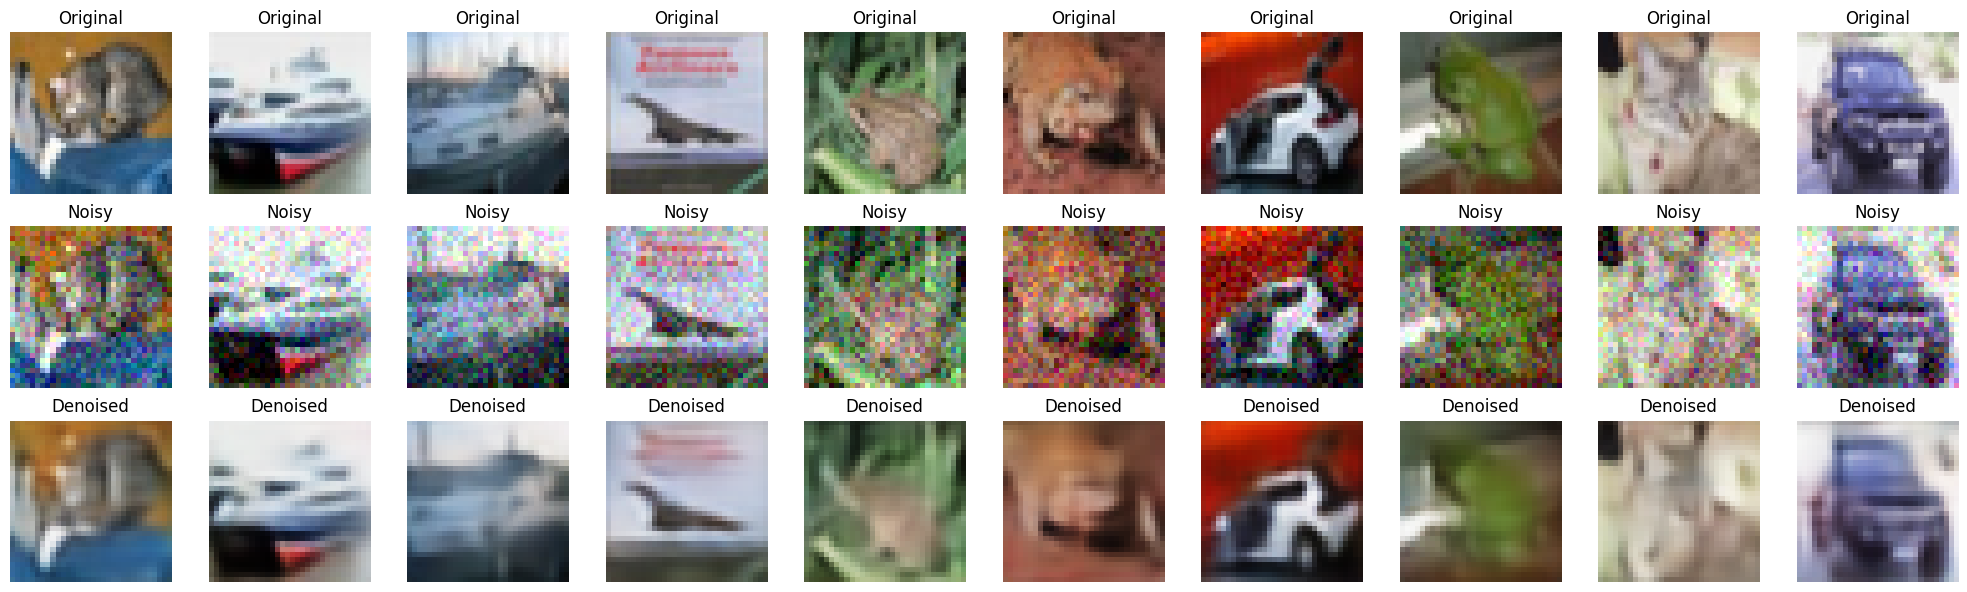

In [21]:
denoised_images = model.predict(test_noisy)

n = 10
plt.figure(figsize = (20,6))
for i in range(n):
    ax = plt.subplot(3,n,i+1)
    plt.imshow(test_images[i].reshape(32,32,3), cmap = 'gray')
    plt.title("Original")
    ax.axis("off")
    
    ax = plt.subplot(3,n,i+1+n)
    plt.imshow(test_noisy[i].reshape(32,32,3), cmap = "gray")
    plt.title("Noisy")
    ax.axis("off")
    
    ax = plt.subplot(3,n,i+1+2*n)
    plt.imshow(denoised_images[i].reshape(32,32,3), cmap = "gray")
    plt.title("Denoised")
    ax.axis("off")
     
plt.tight_layout()
plt.show()

## Question 4: Next, we will try to implement a sparse autoencoder using the MNIST dataset. As mentioned in the class, the sparse encoder works like a regularized autoencoder, which learn useful feature representations by forcing the network to activate only a small number of neurons in the latent (hidden) layer at any given time. Now the first question model we have used is a overcomplete autoencoder. Let’s try to implement the same problem  by including the sparsity constraint in the bottleneck layer.

### Loading the MNIST dataset

In [30]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.


x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test, (len(x_test), 28, 28, 1))

print("Train:", x_train.shape, "Test:", x_test.shape)

Train: (60000, 28, 28, 1) Test: (10000, 28, 28, 1)


In [31]:
train_images, val_images = train_test_split(x_train, test_size=0.2, random_state=42)

noise_factor = 0.5
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
val_noisy   = val_images   + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val_images.shape)
test_noisy  = x_test       + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)


train_noisy = np.clip(train_noisy, 0., 1.)
val_noisy   = np.clip(val_noisy, 0., 1.)
test_noisy  = np.clip(test_noisy, 0., 1.)

print("Train noisy:", train_noisy.shape, "Val noisy:", val_noisy.shape)


Train noisy: (48000, 28, 28, 1) Val noisy: (12000, 28, 28, 1)


In [32]:
from tensorflow.keras import regularizers

model = Sequential()

##vEncoder
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Conv2D(64, (3,3), activation='relu', padding='same',
                 activity_regularizer=regularizers.l1(1e-5))) 
model.add(MaxPooling2D((2,2), padding='same'))

## Decoder
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(1, (3,3), activation='sigmoid', padding='same'))

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

history = model.fit(train_noisy, train_images, 
                    epochs = 50, 
                    batch_size = 128, 
                    shuffle = True, 
                    validation_data = (val_noisy,val_images), 
                    verbose = 1,
                    callbacks = [early_stopping])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8027 - loss: 0.3734 - val_accuracy: 0.8053 - val_loss: 0.1593
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8059 - loss: 0.1513 - val_accuracy: 0.8081 - val_loss: 0.1363
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8089 - loss: 0.1336 - val_accuracy: 0.8101 - val_loss: 0.1282
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8090 - loss: 0.1273 - val_accuracy: 0.8104 - val_loss: 0.1234
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8102 - loss: 0.1226 - val_accuracy: 0.8109 - val_loss: 0.1201
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8107 - loss: 0.1193 - val_accuracy: 0.8120 - val_loss: 0.1181
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8106 - loss: 0.1172 - val_accuracy: 0.8119 - val_loss: 0.1154
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8117 - loss: 0.1146 - val_accuracy: 0

In [37]:
res = model.evaluate(test_noisy, x_test, verbose=1)
print(f"Test loss: {res[0]:.4f}, Test accuracy: {res[1]*100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8195 - loss: 0.0993
Test loss: 0.0999, Test accuracy: 81.23%


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


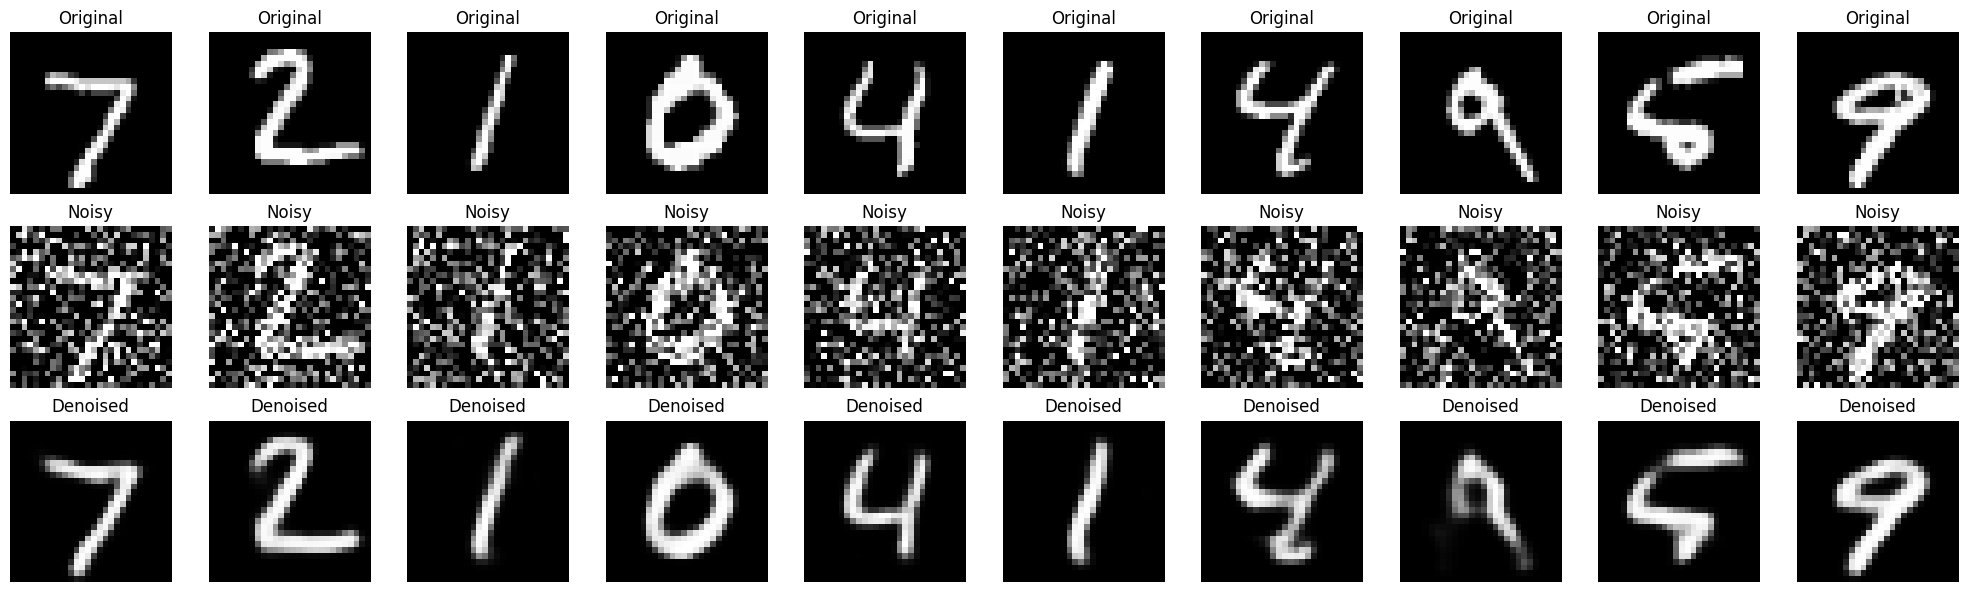

In [40]:
denoised_images = model.predict(test_noisy)
n = 10
plt.figure(figsize = (20,6))
for i in range(n):
    ax = plt.subplot(3,n,i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap = 'gray')
    plt.title("Original")
    ax.axis("off")
    
    ax = plt.subplot(3,n,i+1+n)
    plt.imshow(test_noisy[i].reshape(28,28), cmap = "gray")
    plt.title("Noisy")
    ax.axis("off")
    
    ax = plt.subplot(3,n,i+1+2*n)
    plt.imshow(denoised_images[i].reshape(28,28), cmap = "gray")
    plt.title("Denoised")
    ax.axis("off")
plt.tight_layout()
plt.show()
